In [1]:
#Michael Lust
#801094861
#Real Time AI (4106)
#January 26, 2022

In [2]:
from torchvision import models, datasets, transforms
import torch
import torch.nn as nn

In [3]:
dir(models)

['AlexNet',
 'DenseNet',
 'EfficientNet',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'Inception3',
 'InceptionOutputs',
 'MNASNet',
 'MobileNetV2',
 'MobileNetV3',
 'RegNet',
 'ResNet',
 'ShuffleNetV2',
 'SqueezeNet',
 'VGG',
 '_GoogLeNetOutputs',
 '_InceptionOutputs',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_utils',
 'alexnet',
 'densenet',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'detection',
 'efficientnet',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b2',
 'efficientnet_b3',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'feature_extraction',
 'googlenet',
 'inception',
 'inception_v3',
 'mnasnet',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet',
 'mobilenet_v2',
 'mobilenet_v3_large',
 'mobilenet_v3_small',
 'mobilenetv2',
 'mobilenetv3',
 'quantization',
 'regnet',
 'regnet_x_16gf',
 'regnet_x_1_6gf',
 're

In [4]:
alexnet = models.AlexNet()

In [5]:
#Using ResNet 101
resnet = models.resnet101(pretrained=True)

In [6]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [7]:
#Using ResNetGen

class ResNetBlock(nn.Module): # <1>

    def __init__(self, dim):
        super(ResNetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim)

    def build_conv_block(self, dim):
        conv_block = []

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim),
                       nn.ReLU(True)]

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x) # <2>
        return out


class ResNetGenerator(nn.Module):

    def __init__(self, input_nc=3, output_nc=3, ngf=64, n_blocks=9): # <3> 

        assert(n_blocks >= 0)
        super(ResNetGenerator, self).__init__()

        self.input_nc = input_nc
        self.output_nc = output_nc
        self.ngf = ngf

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=True),
                 nn.InstanceNorm2d(ngf),
                 nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2**i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3,
                                stride=2, padding=1, bias=True),
                      nn.InstanceNorm2d(ngf * mult * 2),
                      nn.ReLU(True)]

        mult = 2**n_downsampling
        for i in range(n_blocks):
            model += [ResNetBlock(ngf * mult)]

        for i in range(n_downsampling):
            mult = 2**(n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=True),
                      nn.InstanceNorm2d(int(ngf * mult / 2)),
                      nn.ReLU(True)]

        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input): # <3>
        return self.model(input)

In [8]:
netG = ResNetGenerator()

In [9]:
netG

ResNetGenerator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): ResNetBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
     

In [10]:
from torchvision import transforms
preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )])

In [11]:
#Problem 1 using ResNet 101

In [12]:
from PIL import Image
img = Image.open("Photos/Tree.jpg")

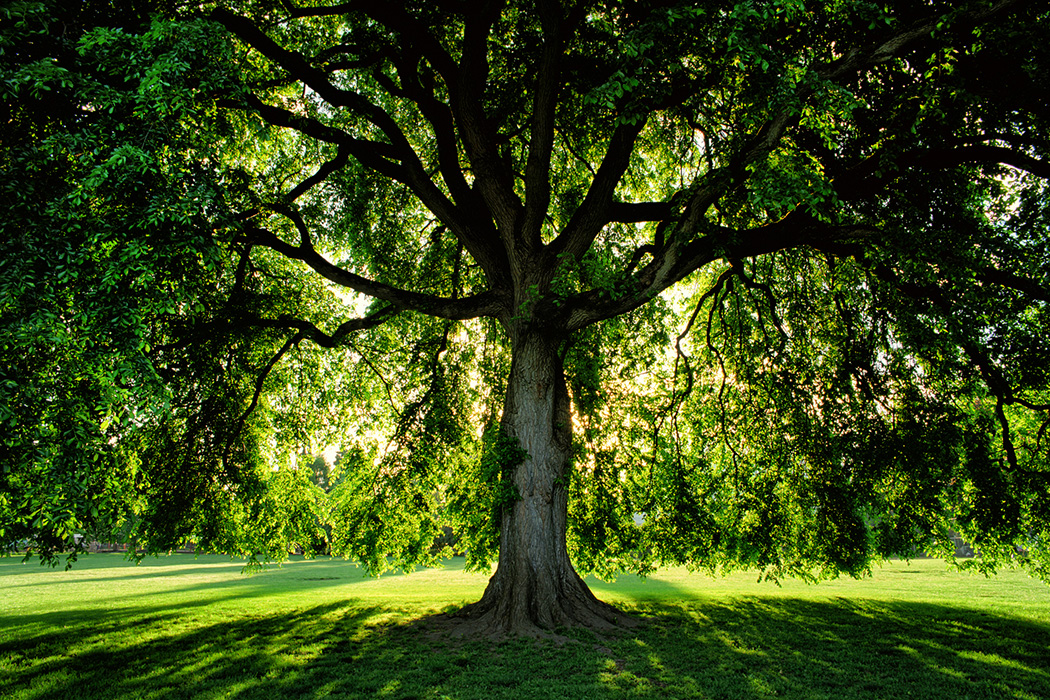

In [13]:
img

In [14]:
img_t = preprocess(img)

In [15]:
batch_t = torch.unsqueeze(img_t, 0)

In [16]:
resnet.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [17]:
out = resnet(batch_t)
out

tensor([[ 3.5744e-01, -6.4321e-01, -4.9288e+00, -3.7835e+00, -2.2021e+00,
         -3.4276e+00, -1.7188e+00,  7.4852e-01,  7.5746e-01,  2.3748e+00,
         -2.8601e+00,  3.7898e-01, -1.0439e+00, -2.2049e+00, -2.9130e-01,
          3.5650e-01, -1.9636e+00, -2.9065e-01,  2.5172e+00, -5.8946e-01,
         -1.1890e+00, -1.4090e+00,  7.4318e-01,  1.3636e+00,  5.0014e-01,
          4.0904e-01, -1.0768e+00,  2.5256e-01, -1.7855e+00, -8.6619e-01,
         -3.6360e-01,  1.2815e+00, -2.1287e+00, -3.7475e+00, -1.1165e+00,
         -1.0891e+00,  1.2780e+00, -9.0332e-01, -2.9976e+00,  2.9652e-01,
          1.0979e+00, -3.1959e+00, -1.9376e+00, -1.4693e+00, -9.2452e-01,
         -1.1618e+00,  3.1905e+00, -5.3129e-01, -2.9711e-01, -1.9720e+00,
         -1.1196e-01,  1.6747e+00, -5.8213e-01, -1.5810e+00, -9.0732e-01,
          3.7753e+00, -2.7379e+00, -1.2587e+00, -1.1096e+00,  3.4094e+00,
          1.7247e+00, -4.9050e-01, -1.6637e+00, -1.2934e+00,  1.7599e+00,
         -1.2519e+00, -1.3718e+00,  8.

In [18]:
with open('imagenet_classes.txt') as f:
    labels = [line.strip() for line in f.readlines()]

In [19]:
_, index = torch.max(out, 1)

In [20]:
percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
labels[index[0]], percentage[index[0]].item()

('park bench', 39.83695602416992)

In [21]:
_, indices = torch.sort(out, descending=True)
[(labels[idx], percentage[idx].item()) for idx in indices[0][:5]]

[('park bench', 39.83695602416992),
 ('stone wall', 23.336936950683594),
 ('rapeseed', 8.642328262329102),
 ('maze, labyrinth', 4.329779624938965),
 ('buckeye, horse chestnut, conker', 3.240825653076172)]

In [22]:
#Problem 3 Part 1 Model Complexity of ResNet 101

In [23]:
from ptflops import get_model_complexity_info

macs, params = get_model_complexity_info(resnet, (3, 256, 256), as_strings=True, print_per_layer_stat=True, verbose=True)
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

ResNet(
  44.549 M, 100.000% Params, 10.252 GMac, 100.000% MACs, 
  (conv1): Conv2d(0.009 M, 0.021% Params, 0.154 GMac, 1.504% MACs, 3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(0.0 M, 0.000% Params, 0.002 GMac, 0.020% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(0.0 M, 0.000% Params, 0.001 GMac, 0.010% MACs, inplace=True)
  (maxpool): MaxPool2d(0.0 M, 0.000% Params, 0.001 GMac, 0.010% MACs, kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    0.216 M, 0.484% Params, 0.889 GMac, 8.668% MACs, 
    (0): Bottleneck(
      0.075 M, 0.168% Params, 0.309 GMac, 3.012% MACs, 
      (conv1): Conv2d(0.004 M, 0.009% Params, 0.017 GMac, 0.164% MACs, 64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(0.0 M, 0.000% Params, 0.001 GMac, 0.005% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(0.037 M

In [24]:
#Problem 2 using ResnetGen

In [25]:
model_path = 'horse2zebra_0.4.0.pth'
model_data = torch.load(model_path)
netG.load_state_dict(model_data)

<All keys matched successfully>

In [26]:
netG.eval()

ResNetGenerator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): ResNetBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
     

In [27]:
preprocess = transforms.Compose([transforms.Resize(256),
                                 transforms.ToTensor()])

In [28]:
img = Image.open("Photos/Horses.jpg")

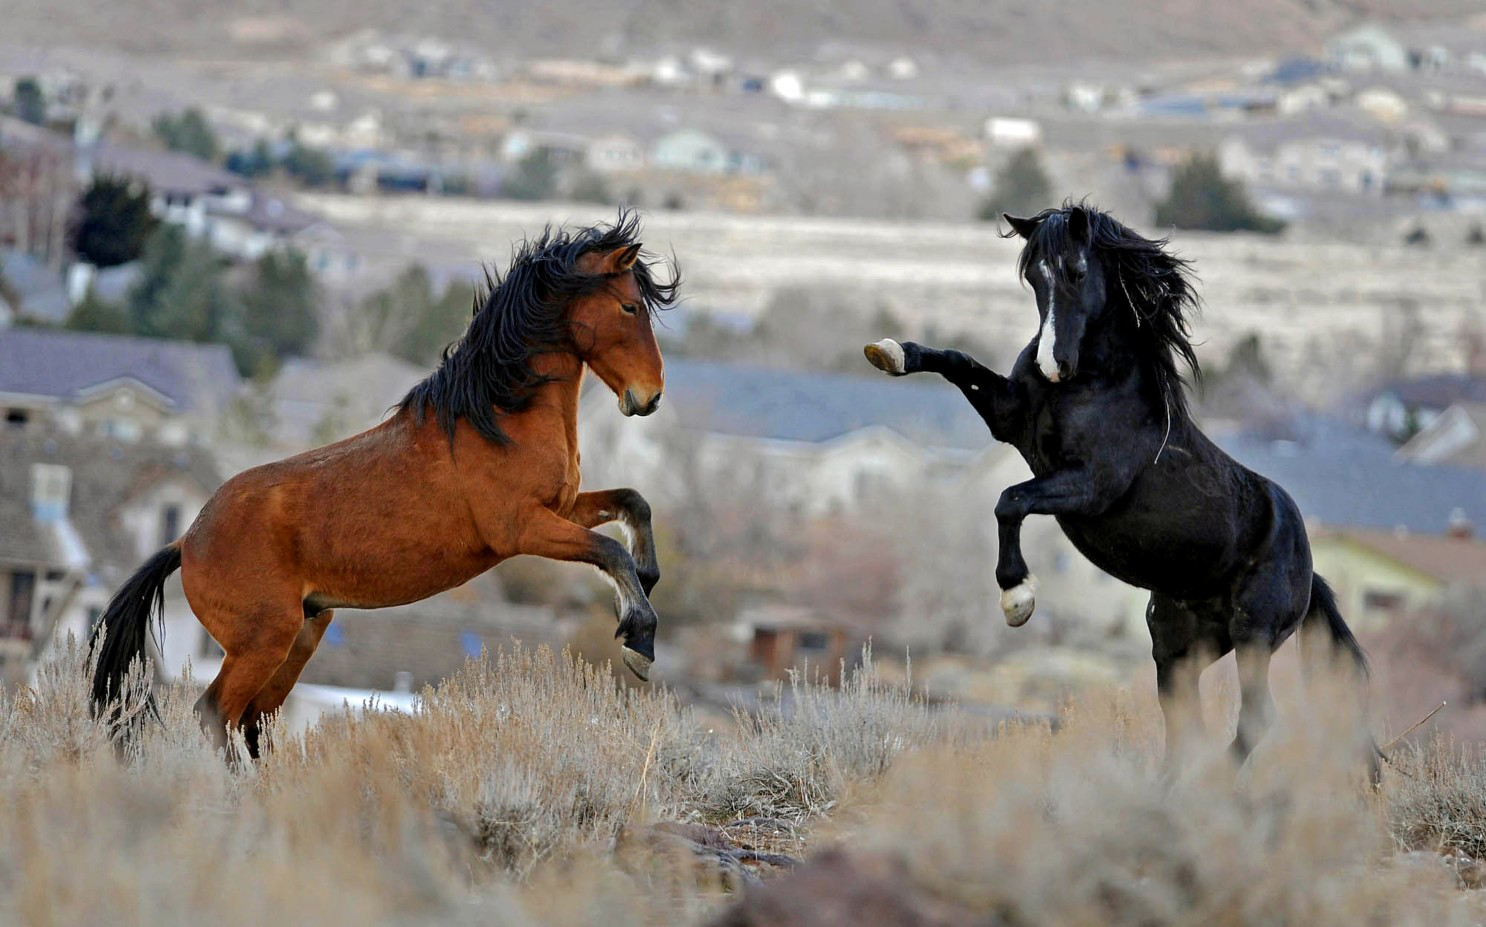

In [29]:
img

In [30]:
img_t = preprocess(img)
batch_t = torch.unsqueeze(img_t, 0)

In [31]:
batch_out = netG(batch_t)

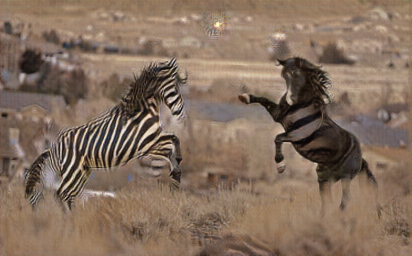

In [32]:
out_t = (batch_out.data.squeeze() + 1.0) / 2.0
out_img = transforms.ToPILImage()(out_t)
out_img

In [33]:
#Problem 3 Part 2 Model complexity of ResnetGen

In [34]:
macs, params = get_model_complexity_info(netG, (3, 256, 256), as_strings=True, print_per_layer_stat=True, verbose=True)
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

ResNetGenerator(
  11.378 M, 100.000% Params, 56.888 GMac, 100.000% MACs, 
  (model): Sequential(
    11.378 M, 100.000% Params, 56.888 GMac, 100.000% MACs, 
    (0): ReflectionPad2d(0.0 M, 0.000% Params, 0.0 GMac, 0.000% MACs, (3, 3, 3, 3))
    (1): Conv2d(0.009 M, 0.083% Params, 0.621 GMac, 1.091% MACs, 3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(0.0 M, 0.000% Params, 0.004 GMac, 0.007% MACs, 64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(0.0 M, 0.000% Params, 0.004 GMac, 0.007% MACs, inplace=True)
    (4): Conv2d(0.074 M, 0.649% Params, 1.21 GMac, 2.127% MACs, 64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(0.0 M, 0.000% Params, 0.002 GMac, 0.004% MACs, 128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(0.0 M, 0.000% Params, 0.002 GMac, 0.004% MACs, inplace=True)
    (7): Conv2d(0.295 M, 2.594% Params, 1.209 GMac, 2.125% MACs, 128, 256, kernel_size=(3, 3),

In [83]:
#Problem 4 Part 1 The MobileNet v2 Architecture 

In [84]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
model.eval()

Using cache found in C:\Users\micha/.cache\torch\hub\pytorch_vision_v0.10.0


MobileNetV2(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05,

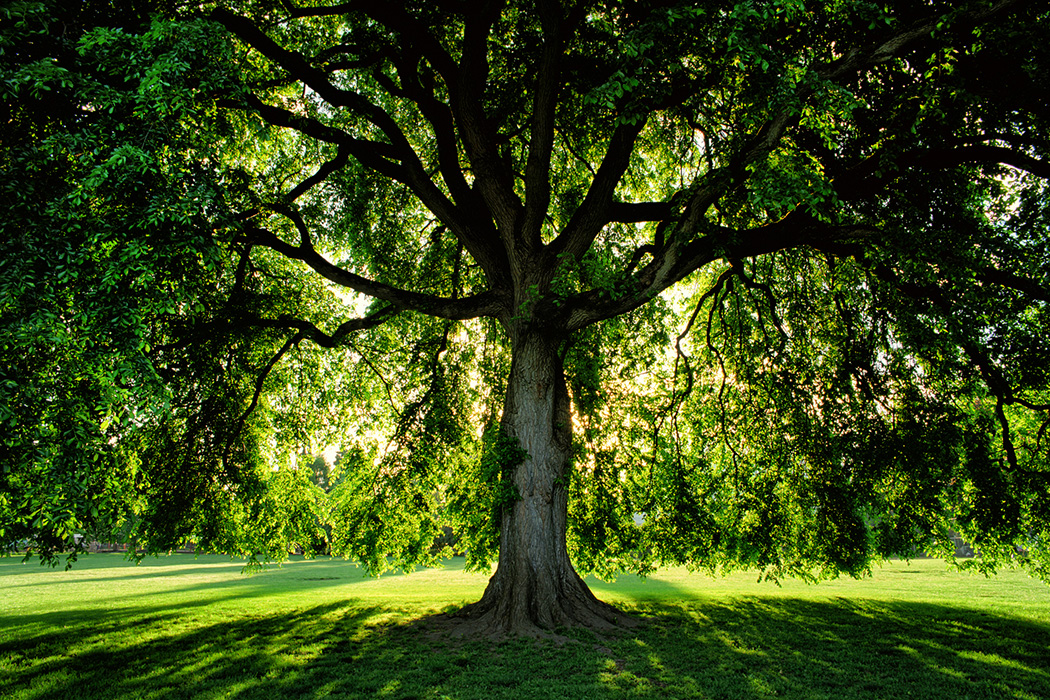

In [85]:
img = Image.open('Photos/Tree.jpg')
img

In [86]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(img)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

In [87]:
# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)
# Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
print(output[0])
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0)
print(probabilities)

tensor([ 9.6205e-01,  1.1914e+00, -3.2603e+00, -3.4328e+00, -2.4607e+00,
        -1.8398e+00, -1.2638e+00,  2.1120e+00,  4.5416e-01,  1.6532e+00,
        -3.7913e+00, -3.6987e-01, -2.2579e-02, -1.7448e+00, -8.3787e-01,
        -8.2092e-01, -3.0778e+00, -3.5763e-01,  1.4749e+00, -4.5269e-02,
        -1.1750e+00, -1.8384e+00,  6.1962e-02,  6.4995e-01, -1.0665e+00,
        -1.2092e+00, -2.5018e+00, -1.5194e+00, -1.8270e+00, -9.7530e-01,
        -8.7564e-01,  6.8520e-02, -2.3940e+00, -3.8389e+00, -1.3178e+00,
        -1.4460e+00,  1.2817e+00, -1.8077e+00, -4.1599e+00, -5.4001e-01,
         9.2189e-01, -3.9729e+00, -1.8453e+00,  9.6083e-01, -7.7700e-01,
         2.8446e-03,  1.9242e+00, -6.4698e-01, -4.1063e-01, -2.9453e-01,
         2.0403e+00,  1.1911e+00, -8.3572e-01, -1.3731e+00, -2.4193e-01,
         2.8280e+00, -1.0035e+00, -1.6230e+00,  6.2604e-01,  3.7537e+00,
         9.8944e-01,  1.2559e+00,  1.4501e+00, -7.3424e-01,  1.1820e+00,
         1.8945e-01, -5.3889e-01,  5.4138e-01, -7.6

In [88]:
# Read the categories
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]
# Show top categories per image
top5_prob, top5_catid = torch.topk(probabilities, 5)
for i in range(top5_prob.size(0)):
    print(categories[top5_catid[i]], top5_prob[i].item())

park bench 0.6023062467575073
stone wall 0.09957990795373917
rapeseed 0.08360651135444641
worm fence, snake fence, snake-rail fence, Virginia fence 0.0158753152936697
lakeside, lakeshore 0.015807919204235077


In [89]:
#Problem 4 Part 2 Model Complexity of the MobileNet v2 architecture 

In [90]:
macs, params = get_model_complexity_info(model, (3, 256, 256), as_strings=True, print_per_layer_stat=True, verbose=True)
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

MobileNetV2(
  3.505 M, 100.000% Params, 0.418 GMac, 100.000% MACs, 
  (features): Sequential(
    2.224 M, 63.451% Params, 0.417 GMac, 99.693% MACs, 
    (0): ConvNormActivation(
      0.001 M, 0.026% Params, 0.016 GMac, 3.764% MACs, 
      (0): Conv2d(0.001 M, 0.025% Params, 0.014 GMac, 3.388% MACs, 3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(0.0 M, 0.002% Params, 0.001 GMac, 0.251% MACs, 32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(0.0 M, 0.000% Params, 0.001 GMac, 0.125% MACs, inplace=True)
    )
    (1): InvertedResidual(
      0.001 M, 0.026% Params, 0.015 GMac, 3.638% MACs, 
      (conv): Sequential(
        0.001 M, 0.026% Params, 0.015 GMac, 3.638% MACs, 
        (0): ConvNormActivation(
          0.0 M, 0.010% Params, 0.006 GMac, 1.506% MACs, 
          (0): Conv2d(0.0 M, 0.008% Params, 0.005 GMac, 1.129% MACs, 32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=Fal